In [ ]:
# pip install transformers datasets torch seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
 

In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import evaluate
import ast
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0 (or specify another GPU ID if needed)


# ✅ Step 1: Load Dataset from CSV
df = pd.read_csv("expanded_tokens_labels.csv")  # Change this to your CSV path

# ✅ Step 2: Load IndicBERT Tokenizer
MODEL_NAME = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# ✅ Step 3: Define NER Labels & Mappings
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-EVT", "I-EVT", "B-PROD", "I-PROD"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# ✅ Step 4: Ensure Correct Data Types and Parse Labels
df = df.dropna().reset_index(drop=True)  # Remove any NaN values
df["Sentence"] = df["Sentence"].astype(str)  # Ensure sentences are treated as strings
df["Label"] = df["Label"].astype(str)  # Ensure labels are strings

# Sometimes, due to earlier processing, some label values might be nested lists.
# Define a helper function to flatten a token (if it's a list, take its first element).
def flatten_label(tag):
    if isinstance(tag, list):
        return tag[0]
    return tag

# Group tokens back into sentences based on Sentence ID.
# After grouping, each "Sentence" and "Label" column will be a list of tokens.
grouped = df.groupby("Sentence ID").agg({"Sentence": list, "Label": list}).reset_index()

# Convert each label (which might be a nested list) to its corresponding ID.
grouped["Label"] = grouped["Label"].apply(lambda x: [label2id.get(flatten_label(tag), 0) for tag in x])

# ✅ Step 5: Split Dataset (Train & Validation)
train_texts, val_texts, train_labels, val_labels, train_ids, val_ids = train_test_split(
    grouped["Sentence"].tolist(),
    grouped["Label"].tolist(),
    grouped["Sentence ID"].tolist(),
    test_size=0.1,
    random_state=42
)

train_dataset = Dataset.from_dict({"tokens": train_texts, "ner_tags": train_labels, "sentence_id": train_ids})
val_dataset = Dataset.from_dict({"tokens": val_texts, "ner_tags": val_labels, "sentence_id": val_ids})

# ✅ Step 6: Tokenize & Align Labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True, padding="max_length", truncation=True, max_length=128)
    labels = []

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore padding tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # For subword tokens, if the original label is greater than 0, keep it; otherwise, mask.
                label_ids.append(label[word_idx] if label[word_idx] > 0 else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["sentence_id"] = examples["sentence_id"]  # Preserve Sentence ID
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)

# ✅ Step 7: Move Model to GPU Explicitly
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
).to("cuda")  # Move the model to GPU

# ✅ Step 8: Define Evaluation Metrics (F1, Precision, Recall, Accuracy)
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id2label[p] for p, l in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "f1": results["overall_f1"],
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "accuracy": results["overall_accuracy"]
    }

# ✅ Step 9: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,  # Reduce batch size
    per_device_eval_batch_size=32,  # Reduce batch size
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir="./logs"
)

# ✅ Step 10: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ✅ Step 11: Train the Model
trainer.train()

# ✅ Step 12: Save Fine-Tuned Model
model.save_pretrained("fine_tuned_indic_ner_model")
tokenizer.save_pretrained("fine_tuned_indic_ner_tokenizer")


/mnt/c/Users/abhis/pytorch-tf-gpu/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/mnt/c/Users/abhis/pytorch-tf-gpu/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit an

Map:   0%|          | 0/41048 [00:00<?, ? examples/s]

Map:   0%|          | 0/4561 [00:00<?, ? examples/s]

/mnt/c/Users/abhis/pytorch-tf-gpu/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/c/Users/abhis/pytorch-tf-gpu/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_22224/1406650145.py:126: 

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.681700,0.608610,0.519237,0.561158,0.483144,0.804130
2,0.538200,0.553276,0.564733,0.600032,0.533357,0.819685
3,0.459400,0.533040,0.583727,0.604045,0.564731,0.826237
4,0.379300,0.555678,0.584527,0.611993,0.559419,0.824644
5,0.309000,0.576079,0.594439,0.602326,0.586756,0.824424
6,0.243300,0.609179,0.590717,0.609304,0.573229,0.826157
7,0.185900,0.668424,0.587994,0.585989,0.590014,0.819605
8,0.137800,0.735460,0.581163,0.583090,0.579249,0.817713
9,0.100100,0.791314,0.578863,0.581115,0.576629,0.817115
10,0.067000,0.838152,0.575522,0.573579,0.577479,0.813889


('fine_tuned_indic_ner_tokenizer/tokenizer_config.json',
 'fine_tuned_indic_ner_tokenizer/special_tokens_map.json',
 'fine_tuned_indic_ner_tokenizer/spiece.model',
 'fine_tuned_indic_ner_tokenizer/added_tokens.json',
 'fine_tuned_indic_ner_tokenizer/tokenizer.json')

### Plotting based on the results obtained above


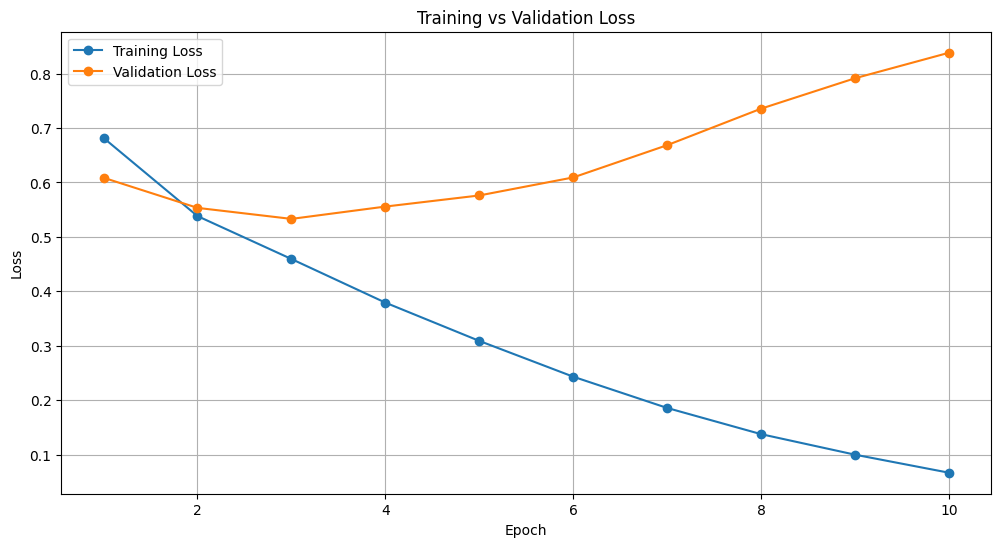

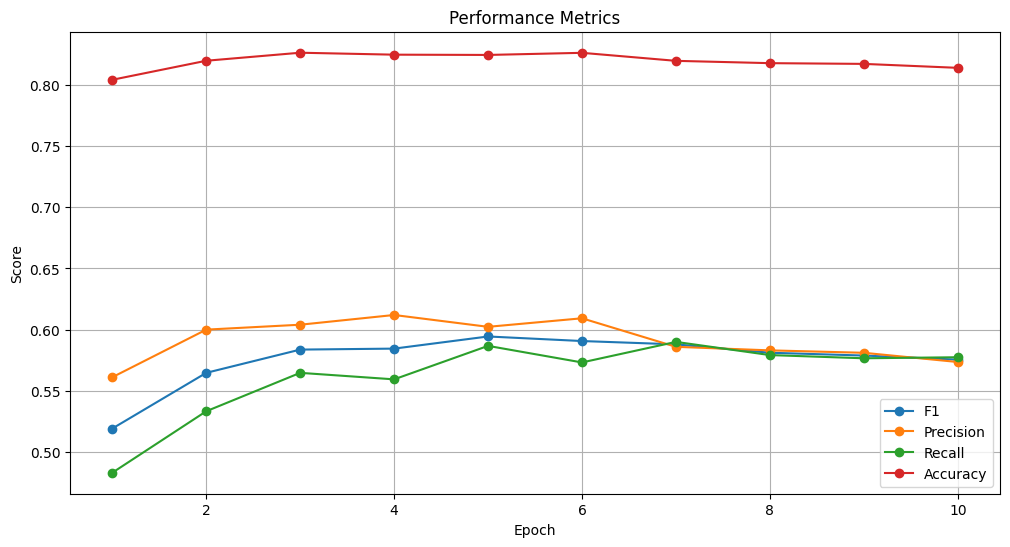

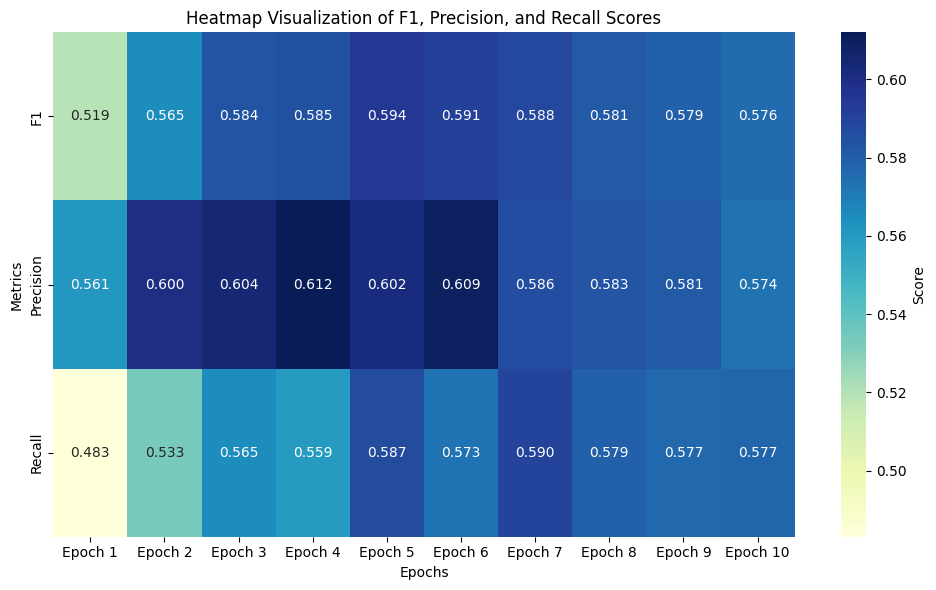

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Epoch": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "Training Loss": [0.681700, 0.538200, 0.459400, 0.379300, 0.309000, 0.243300, 0.185900, 0.137800, 0.100100, 0.067000],
    "Validation Loss": [0.608610, 0.553276, 0.533040, 0.555678, 0.576079, 0.609179, 0.668424, 0.735460, 0.791314, 0.838152],
    "F1": [0.519237, 0.564733, 0.583727, 0.584527, 0.594439, 0.590717, 0.587994, 0.581163, 0.578863, 0.575522],
    "Precision": [0.561158, 0.600032, 0.604045, 0.611993, 0.602326, 0.609304, 0.585989, 0.583090, 0.581115, 0.573579],
    "Recall": [0.483144, 0.533357, 0.564731, 0.559419, 0.586756, 0.573229, 0.590014, 0.579249, 0.576629, 0.577479],
    "Accuracy": [0.804130, 0.819685, 0.826237, 0.824644, 0.824424, 0.826157, 0.819605, 0.817713, 0.817115, 0.813889],
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(df["Epoch"], df["Training Loss"], label="Training Loss", marker="o")
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Metrics (F1, Precision, Recall, Accuracy)
plt.figure(figsize=(12, 6))
plt.plot(df["Epoch"], df["F1"], label="F1", marker="o")
plt.plot(df["Epoch"], df["Precision"], label="Precision", marker="o")
plt.plot(df["Epoch"], df["Recall"], label="Recall", marker="o")
plt.plot(df["Epoch"], df["Accuracy"], label="Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Performance Metrics")
plt.legend()
plt.grid(True)
plt.show()

# Reshape the data for a heatmap
heatmap_data = df[["F1", "Precision", "Recall"]].transpose()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    xticklabels=[f"Epoch {i}" for i in data["Epoch"]],
    yticklabels=["F1", "Precision", "Recall"],
    cbar_kws={"label": "Score"}
)

# Add titles and labels
plt.title("Heatmap Visualization of F1, Precision, and Recall Scores")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()

In [18]:
# !pip install tiktoken


In [3]:
# !pip install --upgrade transformers tiktoken

### Testing

In [4]:
tokenizer.tokenize("This is a भारत example.")

['▁this', '▁is', '▁a', '▁भरत', '▁example', '.']

In [16]:
import os
TOKENIZER_NAME = "/mnt/c/Users/abhis/PycharmProjects/practise and assignments/NER fine-tuning/ner_model/checkpoint-7698"  # Directory containing tokenizer files

print(os.path.exists(TOKENIZER_NAME))  # Should print True


True


### Evaluation(using epoch 3 model)

### Original code

In [9]:
import re
import torch
import string
from transformers import AutoTokenizer, AutoModelForTokenClassification

# ================================================
# Helper Functions
# ================================================

def group_tokens_by_word(input_text, offsets, word_ids, probs, id2label, uncertainty_threshold=0.5):
    """
    Groups tokens into words using the fast tokenizer's word_ids and offsets.
    For each word group, averages the softmax probability vectors, and then selects
    the most probable label. If the maximum probability is below a threshold,
    the group is labeled as "O".
    Returns a list of dictionaries with keys: word_id, start, end, avg_prob, label.
    """
    grouped = {}
    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue  # Skip special tokens
        token_offset = offsets[idx]  # [start, end]
        token_prob = probs[idx]      # probability vector for this token
        if word_id not in grouped:
            grouped[word_id] = {
                "start": token_offset[0],
                "end": token_offset[1],
                "probs": [token_prob],
                "token_indices": [idx]
            }
        else:
            grouped[word_id]["start"] = min(grouped[word_id]["start"], token_offset[0])
            grouped[word_id]["end"] = max(grouped[word_id]["end"], token_offset[1])
            grouped[word_id]["probs"].append(token_prob)
            grouped[word_id]["token_indices"].append(idx)
    
    word_groups = []
    for word_id in sorted(grouped.keys()):
        group = grouped[word_id]
        group_probs = torch.stack(group["probs"], dim=0)  # shape: (n_tokens, num_labels)
        avg_prob = torch.mean(group_probs, dim=0)          # shape: (num_labels,)
        max_prob, label_idx = torch.max(avg_prob, dim=0)
        chosen_label = id2label[label_idx.item()]
        # Fallback: if maximum probability is below the threshold, mark as "O"
        if max_prob.item() < uncertainty_threshold:
            chosen_label = "O"
        word_groups.append({
            "word_id": word_id,
            "start": group["start"],
            "end": group["end"],
            "avg_prob": avg_prob,
            "label": chosen_label,
            "token_indices": group["token_indices"]
        })
    return word_groups

def postprocess_labels(word_groups):
    """
    Given a list of word groups (ordered by word_id), adjust labels for continuity:
    If two consecutive groups share the same entity type (ignoring the B-/I- prefix),
    force the later group’s label to be I-<entity>.
    Returns a list of final labels (in the same order as word_groups).
    """
    final_labels = []
    for i, group in enumerate(word_groups):
        label = group["label"]
        # If the label is not "O", check previous label for continuity.
        if i > 0 and label != "O" and final_labels[-1] != "O":
            prev_entity = final_labels[-1].split("-")[-1]
            curr_entity = label.split("-")[-1]
            if prev_entity == curr_entity:
                # Force the current label to be I-<entity>
                label = "I-" + curr_entity
            else:
                # Otherwise, if current label starts with I- without continuity, force it to B-
                if label.startswith("I-"):
                    label = "B-" + curr_entity
        # Also, if the very first label is I- something, change it to B-
        if i == 0 and label.startswith("I-"):
            label = "B-" + label[2:]
        final_labels.append(label)
    return final_labels

def reconstruct_words(input_text, word_groups):
    """
    Reconstructs words from the input text using the start and end offsets of each word group.
    Returns a list of words.
    """
    words = []
    for group in word_groups:
        word_text = input_text[group["start"]:group["end"]]
        # Optionally, strip extraneous quotes or spaces.
        word_text = word_text.strip(' "')
        words.append(word_text)
    return words

# ================================================
# Main Code
# ================================================

# Step 1: Define model and tokenizer paths
MODEL_NAME = "/mnt/c/Users/abhis/PycharmProjects/practise and assignments/NER fine-tuning/ner_model/checkpoint-3849"
TOKENIZER_NAME = "/mnt/c/Users/abhis/PycharmProjects/practise and assignments/NER fine-tuning/ner_model/checkpoint-3849"

# Step 2: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, local_files_only=True)

# Step 3: Define label mapping
id2label = {
    0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC", 7: "B-EVT", 8: "I-EVT",
    9: "B-PROD", 10: "I-PROD"
}

# Step 4: Prepare input text (raw string)
input_text = '''ఈ వీకెండ్ హైదరాబాద్ లో Jubilee Hills Starbucks లో friends తో chill చేయాలి అనుకుంటున్నా, కానీ Sunday evening varsham పడితే plan cancel కావొచ్చు!'''

# Step 5: Tokenize the raw text with offset mappings and word_ids.
# Do NOT pre-split the text.
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    return_offsets_mapping=True  # returns offsets for each token
)
# Extract offset mappings and word_ids from the fast tokenizer.
offsets = inputs.pop("offset_mapping")[0].tolist()  # List of [start, end] pairs.
word_ids = inputs.word_ids(batch_index=0)            # Maps each token to its originating word (or None).

# Step 6: Perform prediction and compute probabilities.
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits[0]  # shape: (seq_len, num_labels)
probs = torch.softmax(logits, dim=1)  # shape: (seq_len, num_labels)

# Step 7: Group tokens by word.
word_groups = group_tokens_by_word(input_text, offsets, word_ids, probs, id2label, uncertainty_threshold=0.5)

# Reconstruct words exactly as in the original input.
final_words = reconstruct_words(input_text, word_groups)

# Get initial labels from each group.
initial_labels = [group["label"] for group in word_groups]

# Step 8: Post-process labels to enforce continuity and apply uncertainty fallback.
final_labels = postprocess_labels(word_groups)

# Optionally, you could compare majority voting vs. probability selection here.
# For now, we use our probability-averaged labels with fallback.

# ================================================
# Print final word-level predictions.
print("Word-Level Predictions:")
for word, label in zip(final_words, final_labels):
    print(f"{word:20} -> {label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Word-Level Predictions:
ఈ                    -> O
వీకెండ               -> O
హైదరాబాద             -> B-LOC
ల                    -> O
Jubilee              -> B-LOC
Hills                -> I-LOC
Starbucks            -> B-ORG
ల                    -> O
friends              -> O
త                    -> O
chill                -> O
చేయాల                -> O
అనుకుంటున్నా,        -> O
కాన                  -> O
Sunday               -> O
evening              -> O
varsham              -> O
పడిత                 -> O
plan                 -> O
cancel               -> O
కావొచ్చు!            -> O


#### Explanation

# Workflow Summary for NER Code

## Steps in the Code

1. **Input Raw Text**
   - The input is a code-mixed sentence containing Telugu and English words with named entities (e.g., "Jubilee Hills", "Starbucks").

2. **Tokenization**
   - The tokenizer splits the input into subword tokens.
   - Provides additional information:
     - **`offset_mapping`**: Start and end indices of each token in the original text.
     - **`word_ids`**: Maps tokens to corresponding word indices or `None` for special tokens.

3. **Model Prediction**
   - The model computes logits for each token.
   - `softmax` is applied to get probabilities for each NER class.

4. **Grouping Tokens by Word**
   - Tokens belonging to the same word are aggregated.
   - **Average probability vectors** are computed for each word.
   - The most probable label is assigned, or "O" if the probability is below the `uncertainty_threshold` (default: 0.5).

5. **Post-Processing Labels**
   - Ensures continuity in entity spans:
     - Consecutive words with the same entity type follow the `B-` and `I-` convention.
     - Handles incorrect labels starting with `I-`.

6. **Reconstructing Words**
   - Words are reconstructed from their start and end offsets in the input text.

7. **Final Output**
   - Prints word-level predictions in a tabular format:
     ```
     Word-Level Predictions:
     ఈ                   -> O
     వీకెండ్             -> O
     హైదరాబాద్            -> B-LOC
     లో                  -> O
     Jubilee             -> B-LOC
     Hills               -> I-LOC
     Starbucks           -> B-ORG
     ```

## Key Concepts

- **Tokenization with Word Mapping**:
  - Aligns tokens with original words using `offset_mapping` and `word_ids`.

- **NER Model Prediction**:
  - Outputs probabilities for each NER class for every token.

- **Uncertainty Handling**:
  - Words with low confidence (probability < threshold) are labeled as "O".

- **Post-Processing**:
  - Maintains continuity in entity spans using `B-` and `I-` prefixes.

- **Support for Code-Mixed Languages**:
  - Identifies entities in mixed-language inputs effectively.
